# Crafting the DPO dataset


## 0. Data format
We need preference pairs for DPO, so we want the final data format to look like this:

`{"prompt": "our_question", "chosen": "best_answer", "rejected": "less_good_answer"}`

We will use the preference data from milestone 1, and process it to create our preference dataset.

We will also add preference data from [EXTERNAL SOURCES] : TBD


In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../'))

from utils import *

## 1. M1 preference data preprocessing
Loading data from milestone 1 and processing it to the desired format.

### Loading

Let's have a look at the data we have from milestone 1, and see how we can use it to create our dataset.

In [43]:
file_path = "raw data/M1_preference_data_15052024.json"
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

df.head()

,question_id,question_complete,course_id,preference
0,0,Question: Consider the following contains func...,15000,[{'A': 'The asymptotic depth of the contains f...
1,3,Question: What is the asymptotic work of <code...,15000,"[{'A': '...', 'B': '...', 'overall': 'A', 'cri..."
2,4,Question: We have a collection of rectangles i...,15000,[{'A': 'Facts: - Rectangles in the plane have ...
3,5,Question: Which of the following scheduler pol...,15005,[{'A': 'Preemptive scheduling policies allow t...
4,7,"Question: In this week's lecture, you have bee...",15000,"[{'A': 'For the computation g(g(1, x1), g(x2, ..."


### First look at the data
See how it is structured:

In [44]:
len(df)

1522

In [45]:
df.columns

Index(['question_id', 'question_complete', 'course_id', 'preference'], dtype='object')

In [46]:
row = df.iloc[155]
row

question_id                                                       1205
question_complete    Question: Consider the following matrix-factor...
course_id                                                        15127
preference           [{'A': 'To find the optimal value of $b_u$, we...
Name: 155, dtype: object

In [47]:
row['preference']

[{'A': 'To find the optimal value of $b_u$, we need to minimize the objective function with respect to $b_u$. \n\nTaking the derivative of the objective function with respect to $b_u$ and setting it to zero, we get:\n$$\n\\sum_{u \\sim m} (f_{um} - r_{um})\\frac{\\partial f_{um}}{\\partial b_u} + \\lambda b_u = 0\n$$\n\nSince $f_{um} = \\langle \\mathbf{v}_u, \\mathbf{w}_m \\rangle + b_u + b_m$, the partial derivative with respect to $b_u$ is simply 1. Therefore, the equation simplifies to:\n$$\n\\sum_{u \\sim m} (f_{um} - r_{um}) + \\lambda b_u = 0\n$$\n\nRearranging the terms, we get:\n$$\nb_u = \\frac{1}{\\lambda} \\sum_{u \\sim m} (r_{um} - \\langle \\mathbf{v}_u, \\mathbf{w}_m \\rangle - b_m)\n$$\n\nTherefore, the optimal value of $b_u$ is given by the above expression.',
  'B': "To find the optimal value of $b_{u}$, we need to minimize the objective function with respect to $b_{u}$. Let's take the derivative of the objective function with respect to $b_{u}$ and set it to zero to 

We have 1522 questions, and for each question we have N preference pairs (N is not always the same). We will extract the preference pairs from this data according to the preference dictionnaries.

### Extracting single preference dictionaries

The first step is to expand the dataframe so that each row has only one preference dictionary:

In [48]:
expanded_rows = []

for index, row in df.iterrows():
    for pref in row['preference']:
        new_row = row.copy()
        new_row['preference_dict'] = pref
        expanded_rows.append(new_row)

expanded_df = pd.DataFrame(expanded_rows)
expanded_df.drop(columns=['preference'], inplace=True)

expanded_df.head()

,question_id,question_complete,course_id,preference_dict
0,0,Question: Consider the following contains func...,15000,{'A': 'The asymptotic depth of the contains fu...
0,0,Question: Consider the following contains func...,15000,{'A': 'The asymptotic depth of the contains fu...
0,0,Question: Consider the following contains func...,15000,{'A': 'The asymptotic depth of the `contains` ...
0,0,Question: Consider the following contains func...,15000,{'A': 'To determine the asymptotic depth of th...
0,0,Question: Consider the following contains func...,15000,{'A': 'The asymptotic depth of the contains fu...


In [49]:
len(expanded_df)

26738

This gives us 26k disctinct preference pairs from the 1522 questions.

### Prompt cleanup

In [50]:
# Check if each row in 'question_complete' starts with same prefix 'Question: '
prefix_check = expanded_df['question_complete'].apply(lambda x: x.startswith('Question: '))

print("Number of rows starting with 'Question: ':", prefix_check.sum())
print("Number of rows not starting with 'Question: ':", len(prefix_check) - prefix_check.sum())

Number of rows starting with 'Question: ': 26738
Number of rows not starting with 'Question: ': 0


Let's remove the prefix 'Question: ' from the question prompt:

In [51]:
expanded_df['question_complete'] = expanded_df['question_complete'].apply(lambda x: x[10:])

expanded_df.rename(columns={'question_complete': 'prompt'}, inplace=True)

In [52]:
expanded_df['prompt']

0       Consider the following contains function defin...
0       Consider the following contains function defin...
0       Consider the following contains function defin...
0       Consider the following contains function defin...
0       Consider the following contains function defin...
                              ...                        
1521    Consider the transformation from binary MRSW s...
1521    Consider the transformation from binary MRSW s...
1521    Consider the transformation from binary MRSW s...
1521    Consider the transformation from binary MRSW s...
1521    Consider the transformation from binary MRSW s...
Name: prompt, Length: 26738, dtype: object

### prompt formatting

According to HF documentation, prompts for phi should be formatted like this:

`<|system|>
You are a helpful assistant.<|end|>
<|user|>
Question?<|end|>
<|assistant|>`

We will format our data accordingly.

In [53]:
def format_prompt(row):
    formatted_prompt = (
        f"<|system|>"
        f"You are a helpful assistant for a STEM student."
        f"<|end|>"
        f"<|user|>{row['prompt']}<|end|>"
        f"<|assistant|>"
    )
    return formatted_prompt

expanded_df['prompt'] = expanded_df.apply(format_prompt, axis=1)

### Extracting preference pairs
For each row, we set `'chosen'` as the answer defined as best overall in the preference dict, and `'rejected'` as the other answer.

In [54]:
def extract_preferences(row):
    overall = row['preference_dict'].get('overall')
    if overall not in ['A', 'B']:
        return None
    elif overall == 'A':
        chosen = row['preference_dict'].get('A')
        rejected = row['preference_dict'].get('B')
    else:
        chosen = row['preference_dict'].get('B')
        rejected = row['preference_dict'].get('A')
    
    return pd.Series({'chosen': chosen, 'rejected': rejected})

preferences_df = expanded_df.apply(extract_preferences, axis=1)

In [55]:
final_df = pd.concat([expanded_df, preferences_df], axis=1)
final_df = final_df[['prompt', 'chosen', 'rejected']]

In [56]:
final_df.head()

,prompt,chosen,rejected
0,<|system|>You are a helpful assistant for a ST...,"When `contains` is called on a List, the `drop...",The asymptotic depth of the contains function ...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the contains function ...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the `contains` functio...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The contains function is a recursive function ...
0,<|system|>You are a helpful assistant for a ST...,The asymptotic depth of the contains function ...,When the contains function is called on a List...


## 2. M1 preference data filtering
Our data is now in the correct format, we will filter out pairs where:
- `chosen` and `rejected` are the same
- length of prompt or answer is too long


In [57]:
final_df = final_df[final_df['chosen'] != final_df['rejected']]

# We lost a few rows that would have been irrelevant:
len(final_df)

26498

### Length filtering

In [58]:
final_df['prompt_len'] = final_df['prompt'].apply(len)
final_df['c_len'] = final_df['chosen'].apply(len)
final_df['r_len'] = final_df['rejected'].apply(len)
final_df['target_len'] = final_df[['c_len', 'r_len']].max(axis=1)

In [59]:
def len_hist(col_name, title):
    threshold = np.percentile(final_df[col_name], 95)

    # Histogram:
    plt.figure(figsize=(5, 3))
    plt.hist(final_df[col_name], bins=30, color='lightblue', edgecolor='black', alpha=0.7)

    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'95th percentile ({threshold:.2f})')

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title('Length Repartition of '+title)
    plt.legend()

    plt.show()

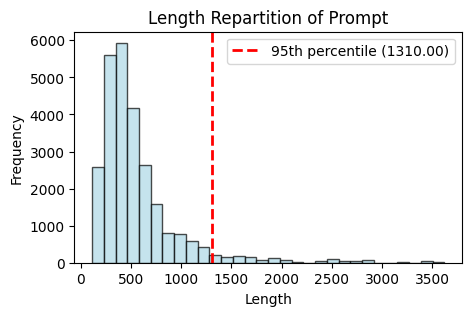

In [60]:
len_hist('prompt_len', 'Prompt')

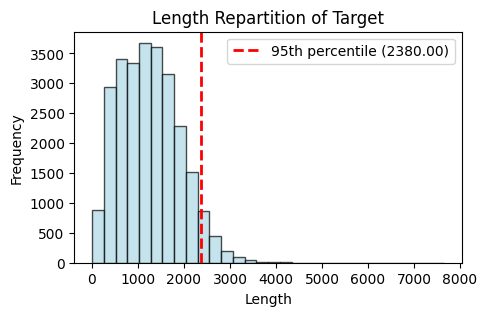

In [61]:
len_hist('target_len', 'Target')

In [62]:
for col_name in ['prompt_len', 'target_len']:
    threshold = np.percentile(final_df[col_name], 95)
    final_df = final_df[final_df[col_name] <= threshold]

In [70]:
print(len(final_df))
print(final_df.prompt_len.max())
print(final_df.target_len.max())

23933
1310
2361


In [71]:
final_df = final_df[['prompt', 'chosen', 'rejected']]
final_df.head()

,prompt,chosen,rejected
0,<|system|>You are a helpful assistant for a ST...,"When `contains` is called on a List, the `drop...",The asymptotic depth of the contains function ...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the contains function ...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the `contains` functio...
0,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The contains function is a recursive function ...
0,<|system|>You are a helpful assistant for a ST...,The asymptotic depth of the contains function ...,When the contains function is called on a List...


## Train / Test split

In [6]:
df = pd.DataFrame(read_jsonl('DPO_data.jsonl'))

train_df, eval_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

train_df.to_json('DPO_train.jsonl', orient='records', lines=True)
eval_df.to_json('DPO_eval.jsonl', orient='records', lines=True)

## End: Save as jsonl

In [76]:
final_df.to_json('DPO_data.jsonl', orient='records', lines=True)

In [2]:
df = pd.DataFrame(read_jsonl('DPO_data.jsonl'))

In [3]:
df.head()

,prompt,chosen,rejected
0,<|system|>You are a helpful assistant for a ST...,"When `contains` is called on a List, the `drop...",The asymptotic depth of the contains function ...
1,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the contains function ...
2,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The asymptotic depth of the `contains` functio...
3,<|system|>You are a helpful assistant for a ST...,To determine the asymptotic depth of the `cont...,The contains function is a recursive function ...
4,<|system|>You are a helpful assistant for a ST...,The asymptotic depth of the contains function ...,When the contains function is called on a List...


In [4]:
len(df)

23933